In [1]:
using StaticArrays

┌ Info: Precompiling StaticArrays [90137ffa-7385-5640-81b9-e52037218182]
└ @ Base loading.jl:1278


In [2]:
using Plots, LinearAlgebra

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1278


In [3]:
import Statistics: mean

In [25]:
using Profile

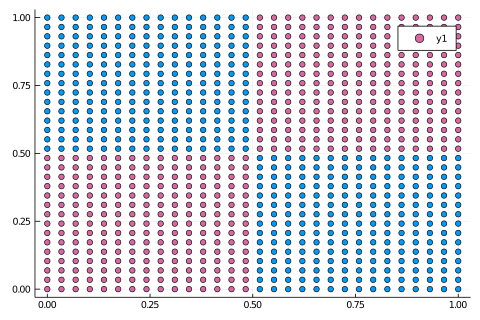

In [467]:
X = collect(hcat(reshape([[x1; x2] for x1 in range(0, stop=1, length=30), x2 in range(0, stop=1, length=30)], 1, :)...)')
Y = [xor(Int(round(x1)),Int(round(x2))) for (x1, x2) in eachrow(X)]
scatter(X[:,1], X[:,2], color=Y, dpi=20)

In [5]:
module MLP
using StaticArrays

sigma(x) = 1/(1+exp(-x))
sigmaprime(x) = sigma(x)*(1-sigma(x))

export NN
mutable struct NN
    w2
    b2
    
    w3
    b3
    
    a1
    a2
    a3
    
    delta2
    delta3
    
    NN(w2, b2, w3, b3) = new(
        w2,
        b2,
        
        w3,
        b3,
        
        undef,
        undef,
        undef,
        
        undef,
        undef
    )
end

export forward
function forward(nn::NN, x)
    w2 = nn.w2
    b2 = nn.b2
    w3 = nn.w3
    b3 = nn.b3
    
    a1 = x
    
    z2 = w2*a1 + b2
    a2 = sigma.(z2)

    z3 = w3*a2 + b3
    a3 = sigma.(z3)
    
    return a3
end

export backpropagate
function backpropagate(nn::NN, x, y)
    # Forward
    w2 = nn.w2
    b2 = nn.b2
    w3 = nn.w3
    b3 = nn.b3
    
    a1 = x
    
    z2 = w2*a1 + b2
    a2 = sigma.(z2)

    z3 = w3*a2 + b3
    a3 = sigma.(z3)
    
    # Backward
    delta3 = (a3 - y) .* sigmaprime.(z3)
    delta2 = (w3'*delta3) .* sigmaprime.(z2)
    
    nn.a1 = a1
    nn.a2 = a2
    nn.a3 = a3
    nn.delta2 = delta2
    nn.delta3 = delta3
end

export gradients
function update_gradients(nn::NN)
    a1 = nn.a1
    a2 = nn.a2
    delta2 = nn.delta2
    delta3 = nn.delta3
    
    dCdb2 = delta2
    dCdb3 = delta3

    dCdw2 = delta2*a1'
    dCdw3 = delta3*a2'

    eta = 5e-2
    
    nn.w2 -= (eta * dCdw2)
    nn.w3 -= (eta * dCdw3)
    nn.b2 -= (eta * dCdb2)
    nn.b3 -= (eta * dCdb3)
end

export train
function train(nn, training_X_Y, weights, iters)
    for epoch in 1:iters
        for (X, Y) in training_X_Y
            backpropagate(nn, X, Y)
            update_gradients(nn)
        end
    end
end
end
import Main.MLP

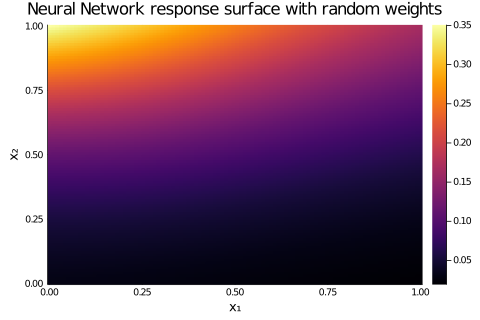

In [173]:
I = 2
H = 100
O = 1

w2 = @MMatrix randn(H, I)
b2 = @MMatrix randn(H, 1)
w3 = @MMatrix randn(O, H)
b3 = @MMatrix randn(O, 1)
nn = MLP.NN(w2, b2, w3, b3)

heatmap(
    range(0, stop=1, length=100),
    range(0, stop=1, length=100),
    (x1, x2) -> MLP.forward(nn, MMatrix{2,1}([x1; x2]))[1],
    title="Neural Network response surface with random weights",
    xlabel="x₁",
    ylabel="x₂",
    dpi=20
)

In [455]:
@time training_X_Y = collect((MMatrix{2,1}([x1;x2]), MMatrix{1,1}([y])) for (x1, x2, y) in eachrow([X Y]));

  0.176611 seconds (142.42 k allocations: 6.802 MiB, 14.20% gc time)


In [8]:
@time MLP.train(
    nn,
    training_X_Y,
    weights,
    500
)

LoadError: UndefVarError: weights not defined

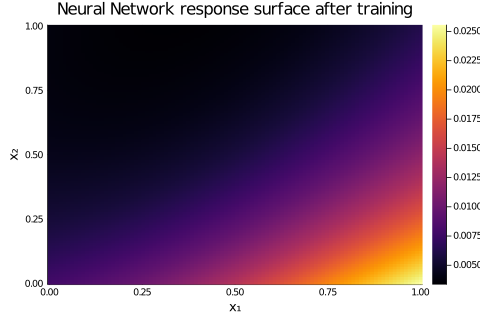

In [13]:
heatmap(
    range(0, stop=1, length=100),
    range(0, stop=1, length=100),
    (x1, x2) -> MLP.forward(nn, SMatrix{2,1}([x1; x2]))[1],
    title="Neural Network response surface after training",
    xlabel="x₁",
    ylabel="x₂",
    dpi=20
)

---

# "Almost" Zero-Allocation Neural Network

In [ ]:
?Matrix

Network creation


  0.000041 seconds (14 allocations: 6.875 KiB)
Prediction
  0.000014 seconds (10 allocations: 2.062 KiB)
Backpropagation
  0.000047 seconds (35 allocations: 10.234 KiB)


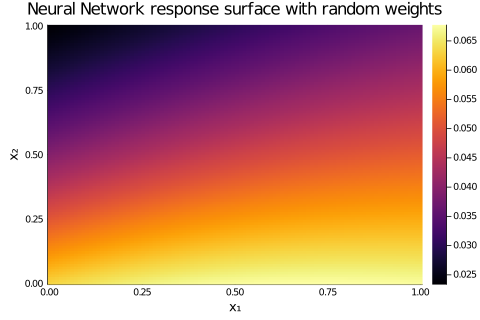

In [657]:
module ZeroAllocationNN
import LinearAlgebra: ⋅
export ZANN
mutable struct ZANN
    weights :: Vector{Matrix{Float64}}
    biases :: Vector{Vector{Float64}}
    
    function ZANN(layer_dims)
        weights = []
        biases = []
        for i = 2:length(layer_dims)
            push!(weights, randn(layer_dims[i], layer_dims[i - 1]))
            push!(biases, randn(layer_dims[i]))
        end
        return new(weights, biases)
    end
end

sigma(x) = 1 / (1 + exp(-x))
sigma_prime(x) = sigma(x)*(1-sigma(x))

export predict
function predict(nn::ZANN, x :: Vector{Float64})
    a = x
    for (w,b) in zip(nn.weights, nn.biases)
        z = w * a + b
        a = sigma.(z)
    end
    return a
end

export backprop
function backprop(nn::ZANN, x :: Vector{Float64}, y :: Vector{Float64})
    # forward pass, the difference from predict is that we save the activations
    # and the weighted inputs
    a = x
    weighted_inputs :: Vector{Vector{Float64}} = []
    activations :: Vector{Vector{Float64}} = [x]
    
    for (w, b) in zip(nn.weights, nn.biases)
        z = w * a + b
        push!(weighted_inputs, z)
        a = sigma.(z)
        push!(activations, a)
    end
    
    # backward pass
    nabla_ws :: Vector{Matrix{Float64}} = []
    nabla_bs :: Vector{Vector{Float64}} = []

    # BP1 (Output layer error)
    delta :: Vector{Float64} = (activations[end] - y) .* sigma_prime.(weighted_inputs[end])
    # BP3 (Cost gradient w.r.t Bias)
    push!(nabla_bs, delta)
    # BP4 (Cost gradient w.r.t weights)
    push!(nabla_ws, delta * activations[end-1]')
    
    for (w, z, a) in Iterators.reverse(zip(nn.weights, weighted_inputs[1:end-1], activations[1:end-2]))
        delta = (w'*delta) .* sigma_prime.(z) # BP2 (Previous layer error)
        push!(nabla_bs, delta)
        push!(nabla_ws, delta * a')
    end
    
    return reverse(nabla_ws), reverse(nabla_bs)
end

end

import Main.ZeroAllocationNN

println("Network creation")
@time zann = ZeroAllocationNN.ZANN([2, 30, 20, 1]);
println("Prediction")
@time ZeroAllocationNN.predict(zann, randn(2));
println("Backpropagation")
@time ZeroAllocationNN.backprop(zann, randn(2), randn(1));

heatmap(
    range(0, stop=1, length=100),
    range(0, stop=1, length=100),
    (x1, x2) -> ZeroAllocationNN.predict(zann, [x1, x2])[1],
    title="Neural Network response surface with random weights",
    xlabel="x₁",
    ylabel="x₂",
    dpi=20
)

In [658]:
@time for epoch in 1:1_000
    for i in 1:length(Y) # For every row instance of the training set
        x = X[i, :]
        y = Y[i]
        nabla_ws, nabla_bs = ZeroAllocationNN.backprop(zann, Vector(x), [float(y)])
        zann.weights -= (0.01 * nabla_ws)
        zann.biases -= (0.01 * nabla_bs)
    end
end

 18.462685 seconds (53.76 M allocations: 20.153 GiB, 21.66% gc time)


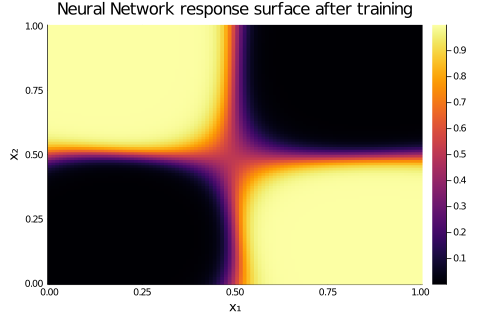

In [659]:
heatmap(
    range(0, stop=1, length=100),
    range(0, stop=1, length=100),
    (x1, x2) -> ZeroAllocationNN.predict(zann, [x1, x2])[1],
    title="Neural Network response surface after training",
    xlabel="x₁",
    ylabel="x₂",
    dpi=20
)